In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from schnet.atoms import stats_per_atom
from schnet.models import SchNet
from schnet.data import ASEReader, DataProvider
from schnet.models import SchNet

In [134]:
# prepares the qm9 database where energy U0 will be the target 
data_reader = ASEReader('qm9.db', # path to database
                        ['energy_U0'], # target property
                        [], [(None, 3)])

In [97]:
std = 1004.55 # standard deviation of energy values for the current training data
mean = -10560.7 # mean of energy values for the current training data

class AtomGenerator(tf.keras.utils.Sequence):
    """Dataloader for batch generation."""
    def __init__(self,data_reader,ids,tar='energy_U0',batch_size=16,shuffle=False):
        self.data = data_reader
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.tar = tar
        self.index = ids
        self.on_epoch_end()

    def __len__(self):
        return len(self.index)//self.batch_size

    def __getitem__(self, index):
        ind = self.index[self.batch_size*index:self.batch_size*(index+1)]
        return self.get_batch(ind)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.index = self.index[np.random.permutation(len(self.index))]
    
    def get_batch(self,idx):
        batch = self.data[idx]
        x_b = batch
        x_b = {k:x[None,...] for k,x in x_b.items()}
        y_b = (batch[self.tar][None,...]-mean)/std # for training we normalize the target values to std==1 and mean==0
        return x_b,y_b

{'aid': array([0]),
 'seg_m': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'idx_ik': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,

In [99]:
# load model
weight_path = 'schnet_weights.h5'

schnet = SchNet(6, 64, 64, 20,
                filter_pool_mode='mean')
schnet.predict(val_provider.__getitem__(1)[0]) # necessary for building the model
schnet.load_weights(weight_path)

In [109]:
batch_size = 1

train_idx, val_idx = train_test_split(np.arange(len(data_reader)),test_size=0.1,random_state=42)

# train_provider = AtomGenerator(data_reader, batch_size=batch_size, ids=train_idx)

val_provider = AtomGenerator(data_reader, batch_size=batch_size, ids=val_idx)

prediction in eV: -418.8401030493824
target in eV: -419.19970091188145
Absolute error in eV: 0.36
Graph of C5NCNOH10 from different perspectives:


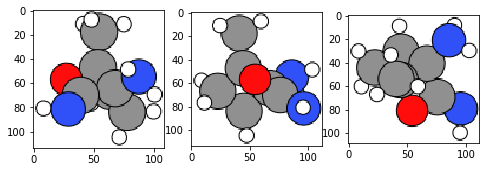

In [103]:
from ase import Atoms
from ase.io import write
from ase.units import Hartree, eV

def view(ind):
    # Select a molecule
    data = mol = val_provider.__getitem__(ind)
    mol = data[0]
    
    # make prediction7
    
    pred = (schnet.predict_on_batch(data[0])*std+mean).numpy().squeeze()*eV/Hartree
    tar = (data[1]*std+mean).squeeze()*eV/Hartree
    print('prediction in eV:',pred)
    print('target in eV:',tar)
    print('Absolute error in eV:',np.round(np.abs(pred-tar),3))
    
    # Get atomic coordinates
    numbers= mol['numbers'].squeeze(0)
    
    # Get atomic symbols
    positions = mol['positions'].squeeze(0)
    
    # Display molecule
    atoms= Atoms(positions= positions, numbers=numbers)
    print(f'Graph of {atoms.symbols} from different perspectives:')
    path = 'image.png'
    write(path, atoms)
    
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(plt.imread(path))
    
    atoms.rotate(90, 'y')
    path = 'image.png'
    write(path, atoms)
    fig.add_subplot(1, 3, 2)
    plt.imshow(plt.imread(path))
    
    atoms.rotate(90, 'x')
    path = 'image.png'
    write(path, atoms)
    fig.add_subplot(1, 3, 3)
    plt.imshow(plt.imread(path))
    plt.show()

    
view(1)

In [108]:

err = 0
val_provider = AtomGenerator(data_reader, batch_size=32, ids=val_idx)
l = len(val_provider)
for count, batch in enumerate(val_provider):

    inp,tar = batch
    # apply model
    pred = schnet.predict_on_batch(inp).numpy()

    # calculate absolute error
    tmp = np.mean(np.abs(pred.squeeze()-tar.squeeze()))
    err += tmp/l
err *= std # scale back to Hartree

print('Test MAE', np.round(err*eV/Hartree, 4), 'eV')

Test MAE 0.3525 eV
